In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [2]:
#Size of our input images
# SIZE = 128        # It was this value at the beginning, but the image display was poor. 
SIZE = 224

# Setting the training and testing datasets 

ImageDataGenerator.flow_from_directory: Takes the path to a directory and generates batches of augmented data.

In [3]:
batch_size = 64
datagen = ImageDataGenerator(rescale=1./255) # Typically used for data augmentation. Here it is only rescaling the image pixels value to range 0 to 1 in decimals

train_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Positive/",
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'          # Class used for working with Autoencoders
    
    )

Found 179 images belonging to 1 classes.


In [4]:
validation_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Positive_val/",
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 30 images belonging to 1 classes.


In [5]:
anomaly_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Anomalies2.0/",
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 6 images belonging to 1 classes.


# Showing one sample of the training set images

Grabbing only one image of one batch of the training set.

In [6]:
images_in_batch = next(train_generator)[0]
print(type(images_in_batch))
print(len(images_in_batch))
print(tf.reduce_min(images_in_batch), tf.reduce_max(images_in_batch))

<class 'numpy.ndarray'>
64
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


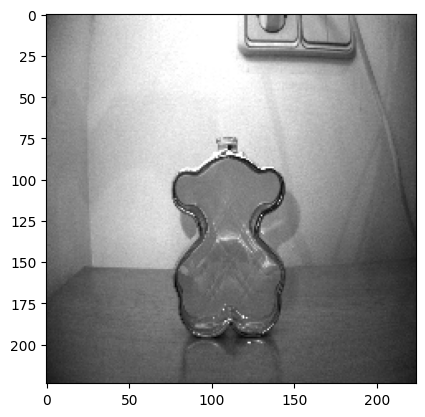

In [7]:
single_img = images_in_batch[0]
plt.imshow(single_img)

# Configuring the Autoencoder netwrok

In [8]:
#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 16)       0

In [9]:
# #Fit the model. 
# history = model.fit(
#         train_generator,
#         epochs=200,
#         validation_data=validation_generator,
#         shuffle = True)

In [10]:
# model_version = 'BottlesModel_TF_v2'
# model.save(f"../../BottlesAnomalies_TFM/models/{model_version}")

Loading the model that was previously saved


In [11]:
model = keras.models.load_model('../models/BottlesModel_TF_v2')
print(type(model))

<class 'keras.engine.sequential.Sequential'>


Get all batches generated by the datagen and pick a batch for prediction

In [12]:
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
# while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
while img_num < len(train_generator):        #I think this should be the correct while clause
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1
    
print("number of batches are: ", img_num)


number of batches are:  3


In [13]:
print(len(data_batch))

3


Predict on the first batch of images. Do also notice that the prediction is being carried out over the images we used for training.

In [14]:
print(data_batch[0].shape)
predicted = model.predict(data_batch[0])  
print(predicted.shape)

(64, 224, 224, 3)
2/2 [==============================] - 1s 448ms/step
(64, 224, 224, 3)


The above is 64 length because it corresponds to the 64 predicted images of a batch. Recall that the predictions are reconstructions of the input images, since we are working with the autoencoder network.

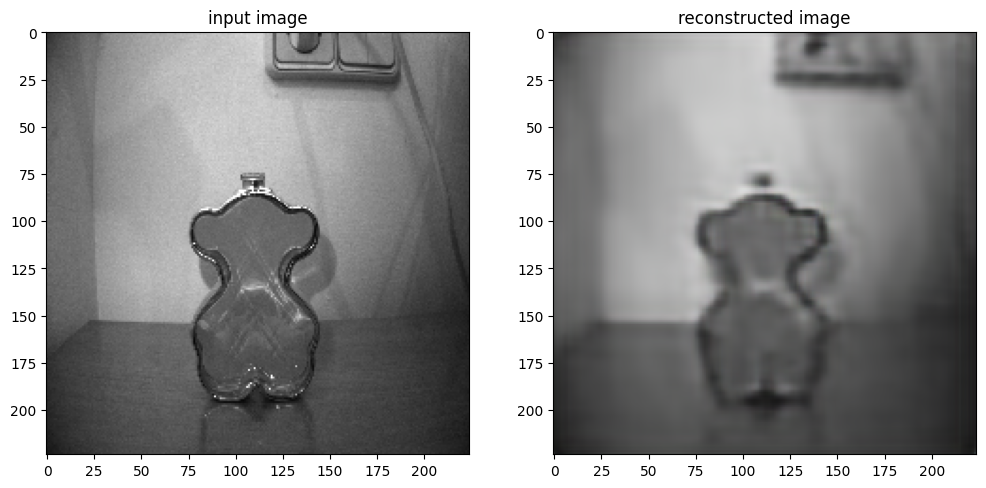

In [15]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(predicted[image_number])
plt.show()

As it can be seen above, the reconstruction is not that good, it is very blurry. 


# Quantifying the reconstruction error

Let us examine the reconstruction error of our validation data (good/normal images) and the anomaly images

In [16]:
validation_error = model.evaluate_generator(validation_generator)
print("Recon. error for the validation (normal) data is: ", validation_error)

C:\Users\alexj\AppData\Local\Temp\ipykernel_26080\2207300971.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  validation_error = model.evaluate_generator(validation_generator)


Recon. error for the validation (normal) data is:  [0.0018939684377983212, 0.0018939684377983212]


Here above we see a vector with two components which happen to be the same between them. This is because in the model, when we define the outputs, the loss function type and the metric are the same parameter, the mse (mean square error).

This reconstruction error above should be very low, since the validation generator is full of normal images (good images)

Whereas the reconstruction error here below, for the "anomaly_generator" should be higher, since this dataset is comprised of full anomaly images.

In [17]:
anomaly_error = model.evaluate_generator(anomaly_generator)
print("Recon. error for the anomaly data is: ", anomaly_error)

C:\Users\alexj\AppData\Local\Temp\ipykernel_26080\4089772597.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  anomaly_error = model.evaluate_generator(anomaly_generator)


Recon. error for the anomaly data is:  [0.0019542204681783915, 0.0019542204681783915]


See that this error is slightly higher than the error in the validation dataset. This is good, but the difference is not that significant and this could result in wrong anomaly detections. Let's see some detections.

SIDENOTE: Additionally, we can check the train generator error according to the "evaluate_generator()" function.

In [32]:
training_error = model.evaluate_generator(train_generator)
print("Recon. error for the training (non-anomaly) data is: ", training_error)

C:\Users\alexj\AppData\Local\Temp\ipykernel_26080\322309295.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  training_error = model.evaluate_generator(train_generator)


Recon. error for the training (non-anomaly) data is:  [0.0018262004014104605, 0.0018262002849951386]


See that the above value does not correspond with the below mean reconstruction error of the training set that will be computed. It should at least be close, I think. This is something to check.

# Computing the reconstruction error without using the "evaluate_generator()" function

The following function computes the reconstrution error per each batch of images. It does, for each of the batches:
- Initialize a vector for storing the reconstruction errors.
- A for loop that traverses all the images contained in a batch.
    - Take the one image of the batch.
    - Add a new size dimension to the image.
    - Make a prediction of the selected image with the model that was built.
    - Evaluate the performance of the prediction, i.e. compute the prediction error.
    - Append the reconstruction error into a list.
- Compute the mean and std deviation of the error.
 

In [18]:
def calc_recon_error(batch_images):   
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]):
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        # reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]    # The batch_size parameter for the moment can be supressed. Results were seen to be the same
        reconstruction_error = model.evaluate([reconstruction],[[img]])[0]
        recon_error_list.append(reconstruction_error)   
    return recon_error_list

In [19]:
total_rec_error = []
for i in range(len(train_generator)):        #I think this should be the correct while clause
    data = train_generator.next()
    total_rec_error.append(calc_recon_error(data[0]))
    
print(len(total_rec_error))

1/1 [==============================] - 0s 39ms/step - loss: 0.0026 - mse: 0.0026
3


In [21]:
print(type(total_rec_error[0]))

<class 'list'>


In [24]:
total_rec_error_list = [item for sublist in total_rec_error for item in sublist]
print(len(total_rec_error_list))

179


In [25]:
na_average_recon_error = np.mean(np.array(total_rec_error_list))  
na_stdev_recon_error = np.std(np.array(total_rec_error_list)) 
min_prob = np.min(total_rec_error_list)
max_prob = np.max(total_rec_error_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_average_recon_error)
print("The standard deviation of the errors list is: ", na_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.0026244744463360674
The standard deviation of the errors list is:  0.0003016621917636844
The min value of the errors list is:  0.0021608255337923765
The max value of the errors list is:  0.0036955196410417557


Compute the average and std dev. of recon. error for positive (anomalies) samples. 


In [27]:
anomaly_batch = anomaly_generator.next()

In [29]:
total_rec_error_anomalies = []
data = anomaly_generator.next()
total_rec_error_anomalies=calc_recon_error(data[0])
print(len(total_rec_error_anomalies))

1/1 [==============================] - 0s 41ms/step - loss: 0.0029 - mse: 0.0029
6


In [31]:
a_average_recon_error = np.mean(np.array(total_rec_error_anomalies))  
a_stdev_recon_error = np.std(np.array(total_rec_error_anomalies)) 
min_prob = np.min(total_rec_error_anomalies)
max_prob = np.max(total_rec_error_anomalies)
print("THIS IS FOR THE ANOMALY IMAGES\n")
print("The average of the errors list is: ", a_average_recon_error)
print("The standard deviation of the errors list is: ", a_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE ANOMALY IMAGES

The average of the errors list is:  0.0027226461097598076
The standard deviation of the errors list is:  0.00042379018127153994
The min value of the errors list is:  0.0023411852307617664
The max value of the errors list is:  0.0035947372671216726


# Coding a function to check if an image contains anomalies

Based on the information shown above, we can set a threshold for discriminating good samples from anomalies ones. 

The following function does:
- Sets the reconstruction error threshold.
- Opens the given image path.
- Resizes the image 
- Depending on the image size it adds a dimension to it. The image must be at the end of this of 3 dimensions in size.
- Converts the image pixel values to float numbers, ranging from 0 to 1. 
- Adds a fourth dimension to the image.
- Performs a prediction using the model and a given image.
- Computes the prediction error.
- Depending on the prediction error it prints the message to whether the image is an anomaly or not. 

In [ ]:
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    reconstruction_error_threshold = 0.006 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    image_shape = img.shape
    if(len(image_shape)==2):
        img = np.dstack((img, img, img))
    plt.imshow(img)
    img = img / 255.
    print(img.shape)
    img = img[np.newaxis, :,:,:]
    
    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if reconstruction_error > reconstruction_error_threshold:
        print("The image IS an anomaly") 
    else:
        print("The image is NOT an anomaly")

In [ ]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
anomaly_file_paths = glob.glob(r'D:\Alex2023\TFM\Images\BottleStoodUp_atNight\Anomalies\Anomalies_samples\*')
positive_file_paths = glob.glob(r'D:\Alex2023\TFM\Images\BottleStoodUp_atNight\Positive\Positive_samples\*')

Checking the anomalies

In [ ]:
num=random.randint(0,len(anomaly_file_paths)-1)
check_anomaly(anomaly_file_paths[num])
print("This image directory is: ", anomaly_file_paths[num])

Checking the positive samples, these are NOT supposed to be anomalies.

In [ ]:
num=random.randint(0,len(positive_file_paths)-1)
check_anomaly(positive_file_paths[num])
print("This image directory is: ", positive_file_paths[num])

From the specific tests above, the model has succesfully discriminated negative samples from the positive ones. However, varifying various images, it was seen that the performance is poor. Next we will label the images so that we can better analyze the results of all of them.

# Labeling the images

Creating the anomalies samples with their correspondant labels

In [ ]:
anomalies_labels = np.ones(6)
print(anomalies_labels)

In [ ]:
anomalies_samples = (anomaly_file_paths,anomalies_labels)

In [ ]:
print("These are the anomalies links: ", anomalies_samples[0])
print("These are the anomalies labels: ", anomalies_samples[1])

Creating the positive samples with their correspondant labels

In [ ]:
positive_labels = np.zeros(len(positive_file_paths))
print(positive_labels)

In [ ]:
positive_samples = (positive_file_paths,positive_labels)
print("These are the positive links: ", positive_samples[0])
print("These are the positive labels: ", positive_samples[1])

Creating a new function baed on "check_anomaly()" that outputs directly the predicted label of the given image. This function is called predict_label()

In [ ]:
def predict_label(img_path):
    reconstruction_error_threshold = 0.006
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    image_shape = img.shape
    if(len(image_shape)==2):
        img = np.dstack((img, img, img))
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
    if reconstruction_error > reconstruction_error_threshold:
        prediction = 1 
    else:
        prediction = 0
    return prediction

In [ ]:
num=random.randint(0,len(positive_file_paths)-1)
model_prediction = predict_label(positive_samples[0][num])
model_label = int(positive_samples[1][num])
print("The model predicts that the given image is: ", model_prediction)
print("The original label of the given image is: ", model_label)

# Using some metrics for evaluating model predictions

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity
from sklearn.metrics import f1_score

## Using the positive samples set. All images are NON-ANOMALIES bottles

We will see first, the precision of the training dataset, which consists on full positive images, i.e. image of bottles without anomalies, their labels are full zeros. 

In [ ]:
positive_samples

In [ ]:
print(len(positive_samples[1]))

In [ ]:
predictions_list = [] 
labels_list = [] 
for i in range(len(positive_file_paths)-1):
    model_prediction = predict_label(positive_samples[0][i])
    model_label = int(positive_samples[1][i])
    predictions_list.append(model_prediction)  
    labels_list.append(model_label)

In [ ]:
print(predictions_list)

### The Precision metric

In [ ]:
pre = Precision()

This metric simply divides true_positives by the sum of true_positives and false_positives.

In [ ]:
pre = Precision()
pre.update_state([0, 1, 1, 1], [1, 0, 1, 1])
pre.result().numpy()

See above that:
- Number of true positives elemnts: 2. The last two "1"s of the second vector.
- Number of false positives: 1. The first "1" of the second vector. 

Then, the precision value of this prediction is: 

= 2/(2+1)

= 0.66667

Below, we have another example of the Precision function. This time it is using the "sample_weight" parameter. This is a mask, wherever there is a "1" the precision metric will be computed.

In [ ]:
pre.reset_state()
pre.update_state([0, 1, 1, 1], [1, 0, 1, 1], sample_weight=[1, 1, 1, 0])
pre.result().numpy()

A final test of the Precision metric before applying it to the real data we are working with.

Notice this case below. The ground truth, the first vector is telling us that there ALL of these samples are positive, i.e. these are normal bottles, bottles without any anomalies.

In [ ]:
pre.reset_state()
pre.update_state([0, 0, 0, 0], [1, 0, 0, 1])
pre.result().numpy()

And the precision value is zero. This is because:
- True positives = 0 
- False positives = 2

Then Precision = 0/(0+2) = 0

Interpreting this result: From all the samples that the model predicted to be anomaly bottles, all of them are wrong predictions. This is because we know that all the bottles were in reality, positive samples, not anomalies at all. 

Let's see the effect of fliping the values of the vectors. Do we arrive to the same conclusion?

In [ ]:
pre.reset_state()
pre.update_state([1 ,1 ,1, 1], [0, 1, 1, 0])
pre.result().numpy()

Now, the precision value is 1. Since:
- True positives = 2
- False positives = 0

Then Precision = 2/(2+0) = 1

This can be interpreted as: Since we have flipped the values, now 0 stands for bottles WITH anomalies and 1 stands for bottles WITHOUT anomalies. Hence, the model has 100% precision at the moment of predicting bottles WITHOUT anomalies. From all the bottles that the model predicted were bottles without anomalies (two bottles), all of them were correct predictions. 

From the tests above, it is clear that we want to see the precision of the model at the moment of predicting bottles WITH anomalies, hence we do:

In [ ]:
pre.reset_state()
pre.update_state(labels_list, predictions_list)
pre.result().numpy()

In [ ]:
print(predictions_list)

As it can be seen the precision is 0%. That is because the model has predicted that some of the bottles DO HAVE anomalies where we know that in reality none of the bottles have any anomaly. 

It is also important to highlight that the optimal case would have been for example:

Ground truth: [0,0,0,0]
Predicted labels: [0,0,0,0]

True positives = 0
False positives = 0
Precision = 0/(0+0) = 0

Leading us to the conclusion that given this case, where all the samples of the ground truth are NOT anomaly bottles, the precision metric by its own might not be enough for explaining the truth performance of the model. 

In [ ]:
pre.reset_state()
pre.update_state([0,0,0,0], [0, 0, 0, 0])
pre.result().numpy()

### The Recall metric

In [ ]:
re = Recall()

The recall metric tells us: out of all the positive examples, how many were predicted as positive? This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

Remember we still working the dataset of full positive samples, i.e. bottles WITHOUT anomalies.

In [ ]:
re.update_state([0,1,1,0], [1, 0, 1, 0])
re.result().numpy()

See above that:
- Number of true positives elemnts: 1. The "1" of the third position of the second vector.
- Number of false negatives: 1. The "0" of the second position of the second vector. 

Then, the recall value of this prediction is: 

= 1/(1+1)

= 0.5

See this other example. Since we do not have any true positive, the recall metric will remain zero.

In [ ]:
re.reset_state()
re.update_state([0,0,0,0], [0,0,1,0])
re.result().numpy()

Flipping the values. Now the ANOMALIES bottles are represented by 0 and the NO-ANOMALIES bottles are represented by 1

In [ ]:
re.reset_state()
re.update_state([1,1,1,1], [1,1,0,1])
re.result().numpy()

See above that:
- Number of true positives elemnts: 3.
- Number of false negatives: 1. 

Recall = 3 / (3+1) = 0.75

We have a recall of 75% of detecting bottles WITHOUT anomalies.

Let's now check with the dataset of this project.

In [ ]:
re.reset_state()
re.update_state(labels_list, predictions_list)
re.result().numpy()

In [ ]:
print(predictions_list)

Since we do not have any true positive the recall value is still 0 for this case. 

And it happens the same as in the Precision metric. See the example below:

In [ ]:
re.reset_state()
re.update_state([0,0,0,0], [0,0,0,0])
re.result().numpy()

Above is shown a fully correct prediction. But still the recall value is zero. This is because no positive sample is present in the ground truth.

### The Specificity metric

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

Specificity = (tn / (tn + fp))

As we are working in here with full NOes, that is bottles WITHOUT anomalies, perhaps this would be a good metric for this case.

In [ ]:
spec = SpecificityAtSensitivity(0.5)  # Not completely sure why to input 0.5 for specificity computation

In [ ]:
spec.update_state([0,1,1,0], [1, 0, 1, 0])
spec.result().numpy()

The examples above consists on:
- True negative detections: 1.
- False positive detections: 1.

Specificity = 1/(1+1) = 0.5

But it does not work very well with other examples. See:

In [ ]:
spec.reset_state()
spec.update_state([0,0,0,0], [0,1,0,0])
spec.result().numpy()

The above result should be:
- True negative detections: 3.
- False positive detections: 1.

Specificity = 3/(3+1) = 0.75

Hence, for the moment the computation of the specificity will be made with an alternative function.

#### Trying the sklearn library for specificity

In [ ]:
from sklearn.metrics import confusion_matrix
import math

tn, fp, fn, tp = confusion_matrix([0,1,1,0], [1, 0, 1, 0]).ravel()
specificity_val = tn/(tn+fp)
if(math.isnan(specificity_val)):
    specificity_val = 0
print("The specificity value is: ", specificity_val)


Above works according to the expected. See another example:

In [ ]:
tn, fp, fn, tp = confusion_matrix([0,0,0,0], [0,1,0,0]).ravel()
specificity_val = tn/(tn+fp)
if(math.isnan(specificity_val)):
    specificity_val = 0
print("The specificity value is: ", specificity_val)

Above as well, it is the expected specificity value. Now try with the actual data of the project.

In [ ]:
tn, fp, fn, tp = confusion_matrix(labels_list, predictions_list).ravel()
specificity_val = tn/(tn+fp)
if(math.isnan(specificity_val)):
    specificity_val = 0
print("The specificity value is: ", specificity_val)

The model has 53.93% of specificity metric detection. This means that, when it comes to detect normal bottles, that is, bottles without anomalies, the model performs it well in 53.93% of the predicitons.

### The Accuracy metric

In [ ]:
acc = BinaryAccuracy()

Compute the frequency with which y_pred matches y_true.

In [ ]:
acc.update_state([0,1,1,0], [1, 0, 1, 0])
acc.result().numpy()

Above we can see:
- The last two numbers match values.
- There are four numbers in total.

Accuracy = 2/4 = 0.5

Applying this to the dataset we are working with:

In [ ]:
acc.reset_state()
acc.update_state(labels_list, predictions_list)
acc.result().numpy()

It outputs a 53.93% of accuracy.

### The Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

Having the predicted and true labels we can generate the confustion matrix. 

In [ ]:

# result = confusion_matrix(labels_list, predictions_list,normalize='pred') #Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(labels_list, predictions_list)
print(result)

Now, to plot the confusion matrix in a very comprehensive way, we use:

In [ ]:
import seaborn as sn
import pandas as pd

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     result.flatten()/np.sum(result)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 
# labels = [f"{v1}\n{v2}" for v1, v2 in
#           zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(result, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

From above, we can see that the model correctly classifies the positive samples, that is, the bottles without anomalies (96 correctly classified). On the other hand, the classifications for anomaly bottles, the model incorrectly classifies 82 samples as anomalies when it should be positive samples.

### The F1 score

This metric is used for creating a great compromise between recall and precision so that you don’t get extreme cases. Consider this example: 

5 pictures of dog, 995 pictures of anything else (imbalanced). We get a classifier running, and it correctly gets one of those dog pictures classified, but calls everything else not-a-dog. That means there are 4 incorrectly classified pictures of dogs. Recall is 0.2 (pretty bad) and precision is 1.0 (perfect), but accuracy, clocking in at 0.999, isn’t reflecting how badly the model did at catching those dog pictures; F1 score, equal to 0.33, is capturing the poor balance between recall and precision.

In [ ]:
# f1 = f1_score([1,0,0,0,0,0,0,0,0,0], [1,1,1,1,1,1,1,1,1,1], average='weighted')
f1 = f1_score([1,0,0,0,0,0,0,0,0,0], [1,1,1,1,1,1,1,1,1,1])
print(f1)

The above, had a precision of:

In [ ]:
pre.reset_state()
pre.update_state([1,0,0,0,0,0,0,0,0,0], [1,1,1,1,1,1,1,1,1,1])
pre.result().numpy()

And a recall of:

In [ ]:
re.reset_state()
re.update_state([1,0,0,0,0,0,0,0,0,0], [1,1,1,1,1,1,1,1,1,1])
re.result().numpy()

See that the F1 score presents a balance between the extreme cases of precision and recall.

Now, let's see the F1 score for the data of our project.

In [ ]:
f1 = f1_score(labels_list, predictions_list)
print(f1)

Since precision and recall metrics for this case were equal to zero, then the F1 score for this dataset is as well zero. 

### The ROC curve

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate.
- False Positive Rate.

As this metric works with a proabability output value, we will have to write a new function for our predictions to output one such value. For the moment we have the "predict_label()" function that, working with a threshold reconstruction error, outputs a prediction of the label, either "1" or "0". Hence, given this situation we have the following possibilites to approach this task:

- Option 1: Map the "reconstruction_error" of each prediction to a probability percentage that ranges from 0 to 100%, where, of course, 100% will correspond to a completely certain prediction. 
- Option 2: Considering the "reconstruction_error_threshold" as the threshold to be varying for the ROC to be built. 


#### Implementing Option 1

First, let's see the error values that the predictions output.

In [ ]:
def output_error(img_path):
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    image_shape = img.shape
    if(len(image_shape)==2):
        img = np.dstack((img, img, img))
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
    return reconstruction_error

In [ ]:
errors_list = []
for i in range(len(positive_file_paths)):
    error_value = output_error(positive_samples[0][i])
    errors_list.append(error_value)  


In [ ]:
print(len(errors_list))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.show()

And some description of the errors list is:

In [ ]:
average_recon_error = np.mean(np.array(errors_list))  
stdev_recon_error = np.std(np.array(errors_list)) 
min_prob = np.min(errors_list)
max_prob = np.max(errors_list)

print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

Having looked at the data points of the errors, the average and the standard deviation of it, we can map the errors to be a percentage probability in the following manner:

- 0.004726, which is the minimum error, can represent a 100% probability of predicting the image as a non-anomaly bottle.
- 0.007921, which is the maximum error, can represent a 60% probability of predicting the image as a non-anomaly bottle. 

The above conclusion is stated because we know we are working with only non-anomaly bottles. Hence, those error values correspond, all of them, to non-anomaly bottles; even the image that outputed the maximum error value must be predicted to be a non-anomaly bottle. 


Moreover, it would be interesting to see as well a plot of the error values of the images that are indeed anomaly bottles. Let's plot them.

In [ ]:
errors_list_anomalies = []
for i in range(len(anomaly_file_paths)):
    error_value = output_error(anomalies_samples[0][i])
    errors_list_anomalies.append(error_value)  

In [ ]:
print(len(errors_list_anomalies))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list_anomalies, np.zeros_like(errors_list_anomalies) + val, 'x')
plt.show()

In [ ]:
average_recon_error = np.mean(np.array(errors_list_anomalies))  
stdev_recon_error = np.std(np.array(errors_list_anomalies)) 
min_prob = np.min(errors_list_anomalies)
max_prob = np.max(errors_list_anomalies)

print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

Let's plot both of the errors values in the same figure.

In [ ]:
plt.figure(figsize=(10, 10))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.plot(errors_list_anomalies, np.zeros_like(errors_list_anomalies) + val, 'ro')
plt.show()

As we can see above, we have a problem. The error values of the anomaly bottles are mixed with the error values of the non-anomaly bottles. It is difficult to draw a line to divide these two categories. However, we can consider of focusing only in the part where most of the non-anomaly bottles error values lie on, that is, if an error value lies into the Guassian distribution of the non-anomaly errors distribution, then it will have more probability of being predicted as such. If the error value lies outside the Gaussian distribution, then the percentage of being detected as such should decrease.

Let's code some function that if:
- The error value is 0.006, which is exactly the average of the non-anomaly distribution, then it should have a 100% probability of being detected as such.
- The error value is 0.006 +/- 0.00049 then the probability of being detected as a non-anomaly bottle is 0%.

The above data is based on the Gaussian distribution of the non-anomaly bottles errors. 

REMINDER: THE ABOVE STATEMENT WAS CHANGED TO:

    - The error value is 0.006, which is exactly the average of the non-anomaly distribution, then it should have a 0% probability of being detected as such.
    - The error value is 0.006 +/- 0.00049 then the probability of being detected as a non-anomaly bottle is 100%.

In [ ]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [ ]:
def map_error2prob(value):
    # Calculate the mean and standard deviation
    mean = 0.006
    std_dev = 0.00049
    aux_score = abs(value - mean)
    if aux_score > 0.00049:
        aux_score = 0.00049
    # prob_score = ranges_mapper(aux_score, 0, std_dev, 100,0)              # This is considering that the 100% refers to a non-anomaly sample
    prob_score = ranges_mapper(aux_score, 0, std_dev, 0,100)                # This is considering that the 100% refers to an anomaly sample
    return prob_score

In [ ]:
print(map_error2prob(0.006))

Once we have the function that maps the reconstruction model error to a probability value, we create a list with all the probabilities values of the predictions. Remember that we are working with only the possitive samples in this section. 

In [ ]:
def map_error2prob_list(input_list):
    # Calculate the mean and standard deviation
    mean = 0.006
    std_dev = 0.00049
    prob_score_list = []
    for i in range (len(input_list)):
        aux_score = abs(input_list[i] - mean)
        if aux_score > 0.00049:
            aux_score = 0.00049
        # prob_score = ranges_mapper(aux_score, 0, std_dev, 100,0)              # This is considering that the 100% refers to a non-anomaly sample
        prob_score = ranges_mapper(aux_score, 0, std_dev, 0,100)                # This is considering that the 100% refers to an anomaly sample
        prob_score_list.append(prob_score)
    return prob_score_list

In [ ]:
len(errors_list)
preds_probs = np.array(map_error2prob_list(errors_list))
preds_probs = preds_probs/100
print("The prediction probabilities list for the positive samples is: ")
print(preds_probs)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
auc_score = roc_auc_score(positive_samples[1], preds_probs)

It is necessary for the ROC score to be computed that there exist in the test set, at least one sample of each class. As in this case we are trying to work with a single-class test set, then the above error is shown. Trying to create a new test set where we mix positive and negative samples.
First, let's take 40 samples out of the positive samples:

In [ ]:
positive_samples_list = []
for i in range (len(positive_file_paths)):
    img_link = positive_samples[0][i]
    img_label = positive_samples[1][i]
    positive_samples_list.append((img_link, img_label)) 
print("The total number of samples in the positive samples list is: ", len(positive_samples_list))

portion_positive_samples = []
for i in range (40):
    index = random.randint(0, len(positive_file_paths)-1)
    portion_positive_samples.append(positive_samples_list[index])
print("The portion that was took of the positive samples list is: ", len(portion_positive_samples))

Now mix these 40 sample with the anomalies samples

In [ ]:
anomalies_samples_list = []
for i in range (len(anomaly_file_paths)):
    img_link = anomalies_samples[0][i]
    img_label = anomalies_samples[1][i]
    anomalies_samples_list.append((img_link, img_label)) 
len(anomalies_samples_list)

In [ ]:
samples_test = []
samples_test = portion_positive_samples
for i in range(len(anomalies_samples_list)):
    samples_test.append(anomalies_samples_list[i])
print(len(samples_test))

Now, we have a test set that is comprised of negative and positive samples. Over this test set we will predict the probability that each of these samples have of being or not an anomaly. 

In [ ]:
errors_list = []
for i in range(len(samples_test)):
    error_value = output_error(samples_test[i][0])
    errors_list.append(error_value)
print(len(errors_list))
preds_probs = np.array(map_error2prob_list(errors_list))
preds_probs = preds_probs/100
print("The prediction probabilities list for the positive samples is: ")
print(preds_probs)

The above is the list of the probabilities of the samples to be a non-anomaly image. The higher the value the more likely for them to be non-anomally bottles. 

REMINDER: THE ABOVE STATEMENT WAS CHANGED TO:

    - The above is the list of the probabilities of the samples to be an anomaly image. The higher the value the more likely for them to be an anomally bottle. 
Extracting now only the labels values of the test set that was created

In [ ]:
test_set_labels = []
for i in range(len(samples_test)):
    label = samples_test[i][1]
    test_set_labels.append(label)
print(test_set_labels)

In [ ]:
auc_score = roc_auc_score(test_set_labels, preds_probs)
print('AUROC = %.3f' % (auc_score))
fpr, tpr, thresholds = roc_curve(test_set_labels, preds_probs)
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

In [ ]:
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % auc_score)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

Comparing the FPR and TPR computation vs what was computed with the scikitlearn library

In [ ]:
def pred_label_onProb(probs_list):
    pred_based_onProb = []
    # prob_threshold = 0.9979607
    prob_threshold = 0.03469472
    for i in range (len(probs_list)):
        if probs_list[i] > prob_threshold:
            prediction = 1                          ## Stands for classifiaction of anomaly bottle
        else:
            prediction = 0
        pred_based_onProb.append(prediction)
    return pred_based_onProb

In [ ]:
predictions_basedOnProbs = pred_label_onProb(preds_probs)
print(predictions_basedOnProbs)

In [ ]:
conf_matrix = confusion_matrix(test_set_labels, predictions_basedOnProbs)
print(conf_matrix)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 
# labels = [f"{v1}\n{v2}" for v1, v2 in
#           zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

The TPR metric, manually computed, is:

In [ ]:
re.reset_state()
re.update_state(test_set_labels, predictions_basedOnProbs)
print("The TPR value is: ",re.result().numpy()) 

The FPR metric, manually computed, is:

In [ ]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The TPR values are: ", _tpr)
print("The FPR value is: ", _fpr)

In [ ]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

See that working now the values computed with the scikitlearn library matches the manually obtained values of FPR and TPR. There is a little difference in some of the thresholds values but this is beleived to be due to the decimals.

In [ ]:
def closest_value(input_list, input_value):
  arr = np.asarray(input_list)
  i = (np.abs(arr - input_value)).argmin()
  return i

In [ ]:
desired_index = closest_value(thresholds,0.28721809)-1
print("The index we want is: ", desired_index)
tpr_from_scikit = tpr[desired_index ]
fpr_from_scikit = fpr[desired_index ]
print("tpr from scikit: ", tpr_from_scikit)
print("fpr from scikit: ", fpr_from_scikit)

At this point we have managed to obtain the ROC curve and formally test all the tpr and fpr out of it. The ROC curve for this particular case is not the optimal one, in fact, it demonstrates that the model has poor performance. Considering the implementation option2 will not be necessary because of the performance of the model itself.  

One more thing that we can do here, is to find the optimal threshold value for this particular project. 

In [ ]:
import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

As seen above, the optimal threshold value is the one that corresponds to 0.56918. Which at the same time corresponds to TPR and FPR values of:

In [ ]:
desired_index = closest_value(thresholds,0.569618)-1
print("The index we want is: ", desired_index)
tpr_from_scikit = tpr[desired_index ]
fpr_from_scikit = fpr[desired_index ]
print("tpr from scikit: ", tpr_from_scikit)
print("fpr from scikit: ", fpr_from_scikit)

We can conclude that for the created test set (the one that combined the 6 anomaly samples with some non-anomaly ones), the model that we have for the moment, has the best performance at:

- Threshold = 0.569618
- TPR = 0.5
- FPR = 0.425


## The AUC score

The AUC score is a summary of the ROC curve. The greater the area under the curve is the better. We typically compare models among them and choose the one that has the biggest AUC.

In our case the AUC score is:

In [ ]:
auc_score = roc_auc_score(test_set_labels, preds_probs)
print('AUROC = %.3f' % (auc_score))

The test is made in the combined test set; the one of anomaly and non-anomaly images. 

## Using the anomalies samples set. All images are ANOMALIES bottles

In [ ]:
anomalies_samples

In [ ]:
predictions_list = [] 
labels_list = [] 
for i in range(len(anomaly_file_paths)-1):
    model_prediction = predict_label(anomalies_samples[0][i])
    model_label = int(anomalies_samples[1][i])
    predictions_list.append(model_prediction)  
    labels_list.append(model_label)

In [ ]:
print(predictions_list)

### The Precision metric

In [ ]:
pre = Precision()

In [ ]:
pre.reset_state()
pre.update_state(labels_list, predictions_list)
pre.result().numpy()

In [ ]:
print("This is the ground truth list: ", labels_list)
print("This is the prediction list: ", predictions_list)

See that from all the elements that the model has predicted to be positive, all of them are correct, that is why the precision value of this model is 100%.

### The Recall metric

In [ ]:
re = Recall()

In [ ]:
re.reset_state()
re.update_state(labels_list, predictions_list)
re.result().numpy()

In [ ]:
print("This is the ground truth list: ", labels_list)
print("This is the prediction list: ", predictions_list)

See that because of the two false negatives, the recall value becomes:

recall = 3 / (3+2) = 0.6

### The Specificity metric

In [ ]:
tn, fp, fn, tp = confusion_matrix(labels_list, predictions_list).ravel()
specificity_val = tn/(tn+fp)
if(math.isnan(specificity_val)):
    specificity_val = 0
print("The specificity value is: ", specificity_val)

The model has 0% of specificity metric detection. This makes sense since in the dataset there does not exist any bottle without anomaly, i.e. no true negative value could be included for the computation. In this kind of dataset, a better metric to look at is the recall metric.

### The Accuracy metric

In [ ]:
acc = BinaryAccuracy()

In [ ]:
acc.reset_state()
acc.update_state(labels_list, predictions_list)
acc.result().numpy()

It outputs a 60% of accuracy.

### The Confusion Matrix

Having the predicted and true labels we can generate the confustion matrix. 

In [ ]:

# result = confusion_matrix(labels_list, predictions_list,normalize='pred') #Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(labels_list, predictions_list)
print(result)

Now, to plot the confusion matrix in a very comprehensive way, we use:

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     result.flatten()/np.sum(result)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]          #To print the group names as well 
# labels = [f"{v1}\n{v2}" for v1, v2 in
#           zip(group_counts,group_percentages)]                    #For printing without the group names labels                    

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(result, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

From above, we can see that the model correctly classifies the anomaly bottles (3 true positives). On the other hand, the classifications for bottles without anomalies, the model incorrectly classifies 2 of them; it classifies as bottles without anomalies where in reality these are bottles with anomalies.